# Stock Predictor IPYNB

Project by Dalton Corriher

## What is the Stock Predictor Notebook?
This Interactive Python Notebook uses a Long short-term memory (LSTM) machine learning algorithm to predict a stocks closing price.

### How to run?
In order to run this file, my recomendation is downloading it and opening it up in Google Colab [https://colab.research.google.com/](https://colab.research.google.com/). When it opens copy and paste the GitHub URL found here: [](). After that I would recommend clicking on the ==Runtime== tab and click ==Run all==. After it connects to the kernel you will be promped to enter a stock ticker which is the abreviation for the stock you want to use the model on. This can be found here [https://finance.yahoo.com/](https://finance.yahoo.com/). Next you will be asked to input the number of days of data that will be used to train the model. The default is 60 which you can use by just pressing the enter key on your keyboard. The program will take about 5 minutes to full train and produce a result for the stock. After a result is produced you can continue predicting for different stocks. Enter done instead of a ticker to get a summary of the predictions and end the program.

<div style="border: 3px solid red; padding: 20px; margin: 20px 0;">

<h1 style="color: red;">⚠️ IMPORTANT DISCLAIMER ⚠️</h1>

<p style="font-size: 18px; color: red;">
<strong><em>This project is for educational purposes only and does NOT constitute financial advice.</em></strong>
</p>

<p style="font-size: 16px;">
The stock predictions generated by this model are based on historical data and do not account for the numerous complex factors that influence stock prices. Real-world stock performance is affected by many variables including:
</p>

<ul>
<li>Economic conditions</li>
<li>Company performance</li>
<li>Global events</li>
<li>Market sentiment</li>
<li>Regulatory changes</li>
</ul>

<p style="font-size: 16px;">
<strong>Never make investment decisions based solely on this or any other prediction model. Always consult with a qualified financial advisor and perform thorough research before investing.</strong>
</p>

</div>

### Run this to make sure the proper libraries are install in your environment.

In [1]:
!pip install yfinance pandas numpy scikit-learn tensorflow matplotlib ipython

## Library Explanations

This notebook uses several Python libraries for data manipulation, analysis, and machine learning. Here's a brief overview of each library and its purpose in our stock prediction model:

1. **yfinance**: 
   - Purpose: Fetches financial data from Yahoo Finance.
   - Usage: We use it to download historical stock price data.

2. **pandas**: 
   - Purpose: Data manipulation and analysis library.
   - Usage: Handles our time series data and provides data structures like DataFrames.

3. **numpy**: 
   - Purpose: Numerical computing library.
   - Usage: Performs efficient operations on arrays and matrices.

4. **sklearn** (scikit-learn):
   - Purpose: Machine learning library.
   - Components used:
     - `train_test_split`: Splits data into training and testing sets.
     - `MinMaxScaler`: Normalizes our data.
     - `mean_squared_error`: Calculates the mean squared error of our predictions.

5. **tensorflow.keras**:
   - Purpose: High-level neural networks API.
   - Components used:
     - `Sequential`: Creates a linear stack of layers for our neural network.
     - `Dense`: Adds a densely connected neural network layer.
     - `LSTM`: Adds a Long Short-Term Memory layer, crucial for our time series prediction.

6. **matplotlib**:
   - Purpose: Plotting library for creating static, animated, and interactive visualizations.
   - Usage: Creates our time series pl
7. **IPython.display**:
   - Purpose: Provides functions for displaying various types of content in IPython environments like Jupyter notebooks.
   - Usage: Used to display text outputs as markdownots and training history graphs.

These libraries work together to fetch data, prepare it for machine learning, create and train our LSTM model, make predictions, and visualize the results.

In [2]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
%matplotlib inline

## Fetching the Data
The fetch_stock_data takes in three parameters, a string ticker to tell the API what stock data to fetch, and two formatted string dates to tell the api what dates to gather the data from. It uses the yfinance download function to get a Pandas Dataframe of the stock data and returns the 'Close' column which is the closing price of the stock. This returns as a Pandas Series.

In [3]:
# Function to fetch stock data
def fetch_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data['Close']

## Preparing the data
The perpare_data function takes in the parameter, data which is a Pandas Series created by the fetch_stock_data function and the look_back parameter which tells the model how many days to look back to make predictions about the next day's price. The function then normalizes the data between the value of 0 and 1 and reshapes the data into a 2D array. The function then uses the look_back parameter to get a sequence of inputs, target values, and the scaler which is used later when making predictions.

In [4]:
def prepare_data(data, look_back):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))
    
    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, 0])
        y.append(scaled_data[i, 0])
    
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    return X, y, scaler

## Creating the model
The create_model takes in the look_back parameter we used in the last function. It uses the Keras Sequential model which is a which is a linear stack of nurtal network layers. We then add our first layer to the model which is a Long short-term memory(LSTM) layer that has 50 simulated neurons and returns the full sequence of outputs for each input sequence. Next we add another 50 unit LSTM layer which returns a singular result. We then add a fully connected or dense layer with a single unit which becomes our output layer. Lastly we compile and configure our model using the [Adam optimizer](https://www.analyticsvidhya.com/blog/2023/09/what-is-adam-optimizer/#:~:text=The%20Adam%20optimizer%2C%20short%20for,Stochastic%20Gradient%20Descent%20with%20momentum.) and uses the mean squared error loss function.

In [5]:
# Function to create LSTM model
def create_model(look_back):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

## Model Training

In [6]:
def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = create_model(X.shape[1])
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    return model, X_test, y_test, history

## Making Predictions

In [7]:
def make_prediction(model, data, scaler, look_back):
    last_60_days = data[-look_back:].values
    last_60_days_scaled = scaler.transform(last_60_days.reshape(-1, 1))
    X_test = np.array([last_60_days_scaled])
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    pred_price = model.predict(X_test)
    pred_price = scaler.inverse_transform(pred_price)
    return pred_price[0][0]

## Plotting the results and training history

In [8]:
def plot_results(data, predicted_price, prediction_date, ticker):
    plt.figure(figsize=(12,6))
    plt.plot(data.index, data.values, label='Actual Prices')
    plt.plot(prediction_date, predicted_price, 'ro', label='Predicted Price')
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [9]:
def plot_training_history(history):
    plt.figure(figsize=(12,6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## Running the full process

In [10]:
def predict_stock_price(ticker):
    start_date = '2010-01-01'
    end_date = pd.Timestamp.today().strftime('%Y-%m-%d')
    
    try:
        data = fetch_stock_data(ticker, start_date, end_date)
        display(Markdown(f"## Stock Price Prediction for {ticker}"))
        display(Markdown(f"Fetched {len(data)} days of stock data for {ticker}"))

        look_back = input("Enter the number of days you want the model to look back to predict the price for the next day(Press Enter for the default of 60 days): ")
        look_back = look_back if look_back else 60
        X, y, scaler = prepare_data(data, look_back)
        display(Markdown("Data prepared for LSTM model"))
        
        model, X_test, y_test, history = train_model(X, y)
        display(Markdown("Model training completed"))
        
        mse = mean_squared_error(y_test, model.predict(X_test))
        display(Markdown(f"Mean Squared Error: {mse:.4f}"))
        
        predicted_price = make_prediction(model, data, scaler, look_back)
        prediction_date = data.index[-1] + pd.Timedelta(days=1)
        display(Markdown(f"Predicted price for {prediction_date.strftime('%Y-%m-%d')}: ${predicted_price:.2f}"))
        
        plot_results(data, predicted_price, prediction_date, ticker)
        plot_training_history(history)
        
        return data, predicted_price, prediction_date
    
    except Exception as e:
        display(Markdown(f"An error occurred: {str(e)}"))
        display(Markdown("Please try another ticker."))
        return None, None, None

In [11]:
def run_multiple_predictions():
    predictions = {}
    while True:
        ticker = input("Enter a stock ticker (or 'done' to finish): ").upper()
        if ticker == 'DONE':
            break
        data, predicted_price, prediction_date = predict_stock_price(ticker)
        if data is not None:
            predictions[ticker] = {
                'data': data,
                'predicted_price': predicted_price,
                'prediction_date': prediction_date
            }
    
    # Summary of predictions
    display(Markdown("Summary of Predictions:"))
    for ticker, prediction in predictions.items():
        print(f"{ticker}: Predicted price for {prediction['prediction_date'].date()}: ${prediction['predicted_price']:.2f}")

### The Main Function

Enter a stock ticker (or 'done' to finish):  aapl


[*********************100%***********************]  1 of 1 completed


## Stock Price Prediction for AAPL

Fetched 3710 days of stock data for AAPL

Enter the number of days you want the model to look back to predict the price for the next day(Press Enter for the default of 60 days):  


Data prepared for LSTM model

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0269 - val_loss: 3.2225e-04
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 3.5056e-04 - val_loss: 3.3557e-04
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 3.5677e-04 - val_loss: 3.4989e-04
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 3.3664e-04 - val_loss: 2.3672e-04
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.9717e-04 - val_loss: 2.3204e-04
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.6951e-04 - val_loss: 2.1594e-04
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.4827e-04 - val_loss: 2.3357e-04
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.4532e-04 - val_loss: 2.2706e-04
Epoch 9/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 2.4262e-04 - val_loss: 2.7140e-04
Epoch 10/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 2.3727e-04 - val_loss: 3.2945e-04
Epoch 11/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.8840e-04 - 

Model training completed

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


Mean Squared Error: 0.0001

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicted price for 2024-10-01: $229.12

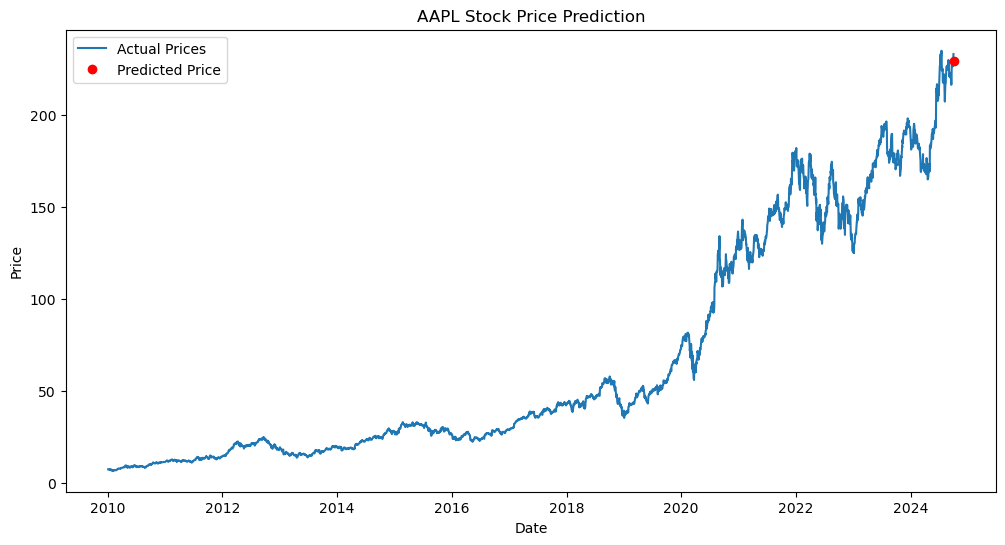

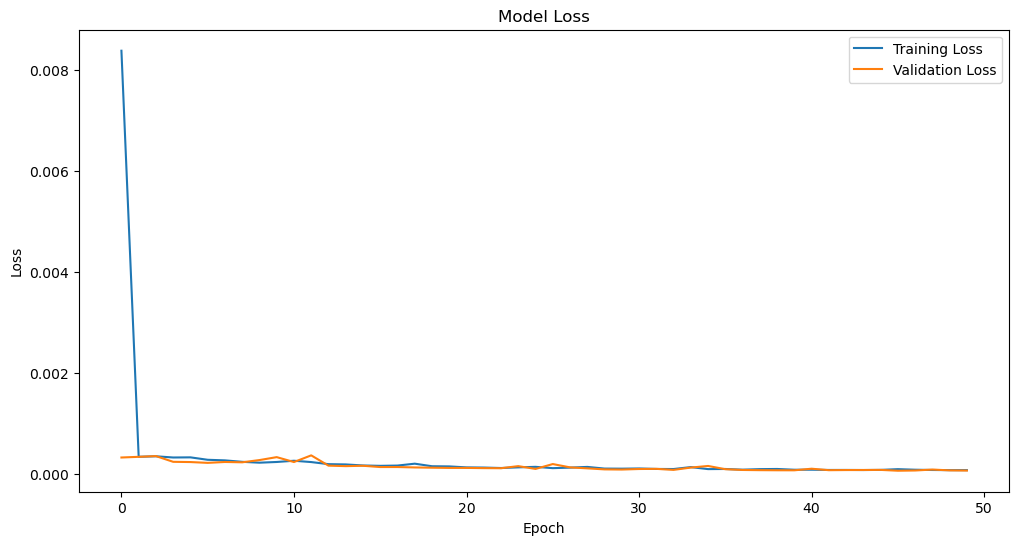

Enter a stock ticker (or 'done' to finish):  done


Summary of Predictions:

AAPL: Predicted price for 2024-10-01: $229.12


In [12]:
run_multiple_predictions()